<a href="https://colab.research.google.com/github/RishabhL7/Pubnew/blob/main/Newdeeplab_Main_500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tqdm import tqdm 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/Data.zip'

In [4]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3
IMG_SIZE = 320

In [5]:
path = "//content/Data/hand_data_train/colour"
maskpath = "/content/Data/hand_data_train/segmentation"

X_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating input data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg = cv2.cvtColor(mpg, cv2.COLOR_BGR2GRAY)
    ret, mpg = cv2.threshold(mpg, 120, 255, cv2.THRESH_BINARY)
    mpg=np.expand_dims(mpg,axis=-1)
    Y_train[m]=mpg/255
    m+=1

creating input data


100%|██████████| 2000/2000 [00:04<00:00, 400.21it/s]


In [16]:
path = "/content/Data/hand_data_test/colour"
maskpath = "/content/Data/hand_data_test/segmentation"
p1 = os.listdir(path)
p1.sort()

m1 = os.listdir(maskpath)
m1.sort()

X_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating test data')
n=0
for name in tqdm(p1):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test[n]=img
    n+=1

m=0
for name in tqdm(m1):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg = cv2.cvtColor(mpg, cv2.COLOR_BGR2GRAY)
    ret, mpg = cv2.threshold(mpg, 120, 255, cv2.THRESH_BINARY)
    mpg=np.expand_dims(mpg,axis=-1)
    Y_test[m]=mpg/255
    m+=1

creating test data


100%|██████████| 1000/1000 [00:02<00:00, 397.88it/s]


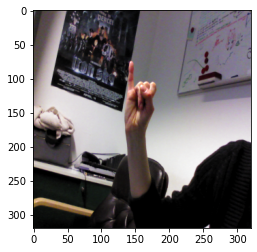

In [6]:
plt.imshow(array_to_img(X_train[0]))

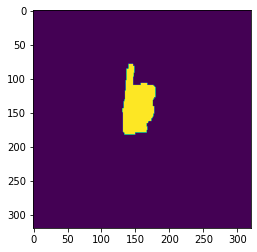

In [7]:
plt.imshow(array_to_img(Y_train[0]))

In [8]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

Model

In [9]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [10]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [11]:
def DeeplabV3Plus(image_size):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    x = layers.Conv2D(1,1)(x)
    x = keras.layers.Activation("sigmoid")(x)

    return keras.Model(inputs=model_input, outputs=x)

In [12]:
model = DeeplabV3Plus(IMG_SIZE)

94781440/94765736 [==============================] - 1s 0us/step


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

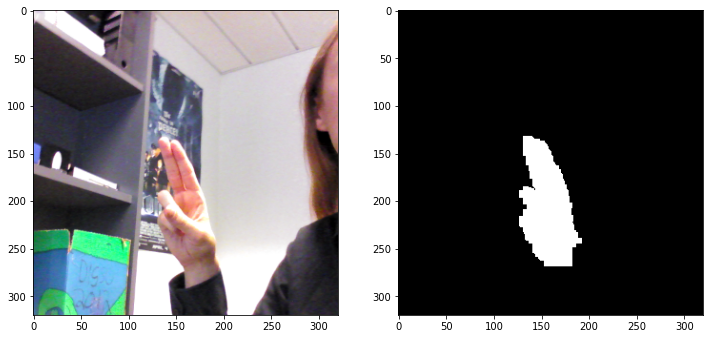

In [14]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(array_to_img(Y_train[image_number]), cmap='gray')
plt.show()

In [15]:
model.compile(loss=dice_loss, optimizer=Adam(1e-4), metrics=[dice_coef, iou, "accuracy"])

In [17]:
path = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/deeplabv3plus"
os.mkdir(path)
checkpoint_path_segmentdeeplab = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/deeplabv3plus/cp.ckpt"
model_checkpoint_segmentdeeplab = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentdeeplab,
                                                                     save_weights_only=True,
                                                                     monitor='val_iou',
                                                                     mode="max",
                                                                     save_best_only=True,
                                                                     verbose=1,
                                                                     save_freq='epoch',
                                                                     period=100)

In [19]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=16, epochs=500, callbacks=[model_checkpoint_segmentdeeplab])

Epoch 1/500
125/125 [==============================] - 64s 394ms/step - loss: 0.1542 - dice_coef: 0.8458 - iou: 0.7520 - accuracy: 0.9703 - val_loss: 0.3212 - val_dice_coef: 0.6784 - val_iou: 0.5181 - val_accuracy: 0.9353
Epoch 2/500
125/125 [==============================] - 47s 375ms/step - loss: 0.0665 - dice_coef: 0.9335 - iou: 0.8755 - accuracy: 0.9880 - val_loss: 0.1278 - val_dice_coef: 0.8719 - val_iou: 0.7770 - val_accuracy: 0.9736
Epoch 3/500
125/125 [==============================] - 47s 375ms/step - loss: 0.0556 - dice_coef: 0.9444 - iou: 0.8947 - accuracy: 0.9893 - val_loss: 0.1122 - val_dice_coef: 0.8878 - val_iou: 0.8022 - val_accuracy: 0.9771
Epoch 4/500
125/125 [==============================] - 47s 375ms/step - loss: 0.0487 - dice_coef: 0.9513 - iou: 0.9072 - accuracy: 0.9903 - val_loss: 0.1062 - val_dice_coef: 0.8939 - val_iou: 0.8119 - val_accuracy: 0.9781
Epoch 5/500
125/125 [==============================] - 51s 409ms/step - loss: 0.0435 - dice_coef: 0.9565 - iou: 

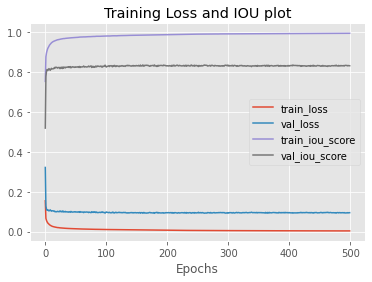

In [21]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 500
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), history.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epochs")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

Text(0, 0.5, 'Accuracy')

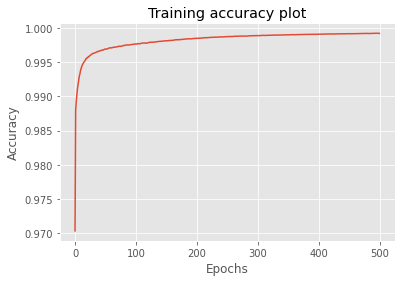

In [22]:
plt.plot(np.arange(0,N), history.history["accuracy"])
plt.title("Training accuracy plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

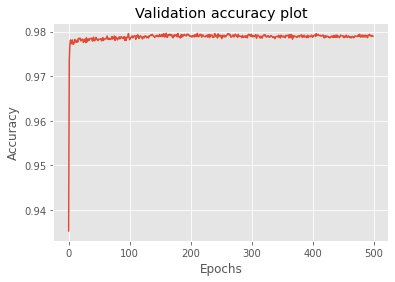

In [23]:
plt.plot(np.arange(0,N), history.history["val_accuracy"], label = "val_accuracy")
plt.title("Validation accuracy plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

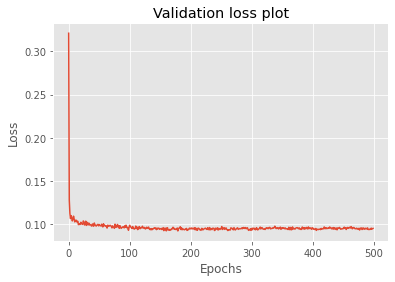

In [24]:
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

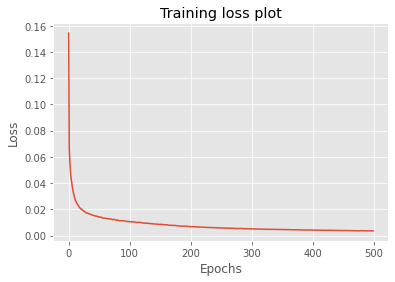

In [25]:
plt.plot(np.arange(0,N), history.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [26]:
model.save('/content/drive/MyDrive/Colab Notebooks/model_deeplabv3plus_main.h5')
model.save_weights('/content/drive/MyDrive/Colab Notebooks/model_deeplabv3plus_weights.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [27]:
y_pred=model.predict(X_test)

In [28]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8337686324282482


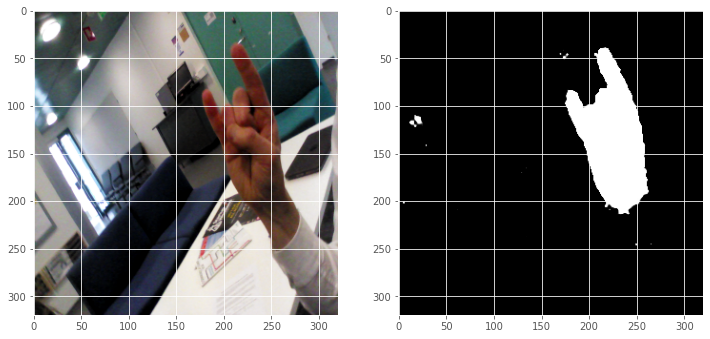

In [29]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()